# PS3

### Laurence Warner

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import math
import scipy.optimize as opt
from scipy import integrate
import pandas as pd

## 1

## a

In [2]:
incomes = np.loadtxt('incomes.txt')
incomes[0:10]

array([ 53711.54439888,  99731.23334901,  84773.60541676,  75184.025931  ,
        73390.9559334 ,  77276.56474964,  82597.32702898,  76098.11372822,
        91850.97696668,  71750.0904012 ])

In [11]:
%matplotlib inline

Text(0,0.5,'Density')

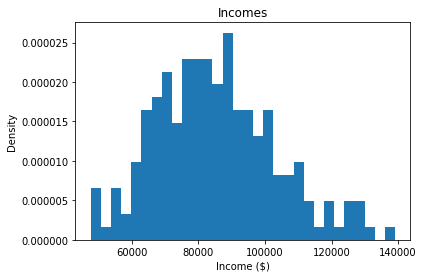

In [12]:
count, bins, patches = plt.hist(incomes, bins = 30, normed = True)
plt.title('Incomes')
plt.xlabel('Income ($)')
plt.ylabel('Density')

### b

In [13]:
data1 = incomes.mean()
data1

85276.823606258113

In [14]:
data2 = incomes.std()
data2

17992.542128046523

In [211]:
DATA_MOMENTS = np.array([[data1],[data2]])

In [212]:
W = np.eye(2)
W

array([[ 1.,  0.],
       [ 0.,  1.]])

Method 1: theory

In [213]:
def theory(params):
    mu, sigma = params
    mean = np.exp(mu + sigma**2/2)
    sd = np.sqrt((np.exp(sigma**2)-1)*np.exp(2*mu+sigma**2))
    model_moments = np.array([[mean],[sd]])
    return model_moments

In [214]:
PARAMS_EX = (11.0, 0.5)
lognormal_moments(PARAMS_EX)

array([[ 76879.91976468],
       [ 36158.02610735]])

Method 2: integrate

In [215]:
def lognormal_pdf(x, params):
    mu, sigma = params
    pdf = 1/x/sigma/np.sqrt(2*np.pi) * np.exp(-(np.log(x)-mu)**2/2/sigma/sigma)
    return pdf

In [216]:
def model_moms(params):
    xfx = lambda x: x * lognormal_pdf(x, params)
    mean = integrate.quad(xfx, 0, 100000000)[0]
    x2fx = lambda x: (x - mean)**2 * lognormal_pdf(x, params)
    var = integrate.quad(x2fx, 0, 100000000)[0]
    sd = np.sqrt(var)
    model_moments = np.array([[mean],[sd]])
    return model_moments

Almost identical!!

In [219]:
def err_vec(params, data_moments):
    model_moments = model_moms(params)
    err_vec = (model_moments - data_moments)/model_moments
    return err_vec

In [243]:
def crit(params, *args):
    data_moments, W = args
    e = err_vec(params, data_moments)
    crit = np.dot(e.transpose(), np.dot(W, e))
    return crit

In [228]:
a = (DATA_MOMENTS, W)
PARAMS_INIT = PARAMS_EX

In [245]:
res = opt.minimize(crit, PARAMS_INIT, a, bounds= ((None, None), (0.1, None)))
res

      fun: array([[  1.46015357e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.90998433e-08,   2.15901796e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 8
   status: 0
  success: True
        x: array([ 11.33188088,   0.20869665])

In [234]:
print("mean: {:.2f}, sig: {:.2f}".format(res.x[0], res.x[1]))

mean: 11.33, sig: 0.21


versus ML estimates. Mu: 11.359, Sigma: 0.208

In [235]:
gmm_params = (res.x[0],res.x[1])

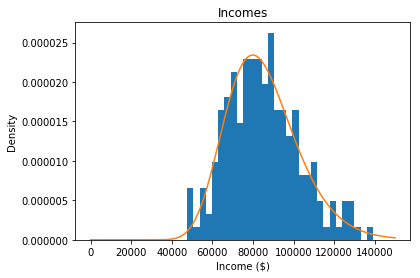

In [236]:
count, bins, patches = plt.hist(incomes, bins = 30, normed = True)
plt.title('Incomes')
plt.xlabel('Income ($)')
plt.ylabel('Density')
x = np.linspace(1, 150000, 1000)
y_max = lognormal_pdf(x, gmm_params)
plt.plot(x, y_max)

In [237]:
print("GMM criterion function at minimum is", res.fun)

GMM criterion function at minimum is [[  1.46015357e-15]]


In [238]:
DATA_MOMENTS

array([[ 85276.82360626],
       [ 17992.54212805]])

In [239]:
model_moms(gmm_params)

array([[ 85276.82609625],
       [ 17992.54168455]])

almost identical

c) not sure

d

In [275]:
n = incomes.size
poor = incomes < 75000
medium1 = 75000 <= incomes
medium = incomes[medium1] <= 100000
medium
rich = 100000 <= incomes 
poor = poor.sum()/n
med = medium.sum()/n
rich = rich.sum()/n

In [276]:
DATA_MOMENTS = np.array([[poor], [med], [rich]])
DATA_MOMENTS

array([[ 0.3],
       [ 0.5],
       [ 0.2]])

In [277]:
def model_moms_3(params):
    def area(a, b):
        a = integrate.quad(lognormal_pdf, a, b, args = ((params,)))[0]
        return a
    poor = area(0, 75000)
    medium = area(75000, 100000)
    rich = area(100000,np.inf)
    m = np.array([[poor], [medium], [rich]])
    return m

In [278]:
def err_vec_3(params, data_moments):
    model_moments = model_moms_3(params)
    err_vec = (model_moments - data_moments)/model_moments
    return err_vec

In [272]:
def crit(params, *args):
    data_moments, W = args
    e = err_vec_3(params, data_moments)
    crit = np.dot(e.transpose(), np.dot(W, e))
    return crit

In [279]:
W = np.eye(3)
a = (DATA_MOMENTS, W)
PARAMS_INIT = PARAMS_EX

In [282]:
res = opt.minimize(crit, PARAMS_INIT, a, bounds= ((None, None), (0.1, None)))
res

/Users/laurencewarner/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


      fun: array([[  7.13214379e-14]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.54939923e-06,  -2.49749002e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 9
   status: 0
  success: True
        x: array([ 11.33568135,   0.21059842])

In [283]:
res.x

array([ 11.33568135,   0.21059842])

In [284]:
gmm_3_params = (res.x[0],res.x[1])

Model and data moments are almost identical:

In [286]:
model_moms_3(gmm_3_params)

array([[ 0.29999994],
       [ 0.50000008],
       [ 0.19999999]])

In [287]:
DATA_MOMENTS

array([[ 0.3],
       [ 0.5],
       [ 0.2]])

In [288]:
print("minimal value of criterion function:", res.fun)

minimal value of criterion function: [[  7.13214379e-14]]


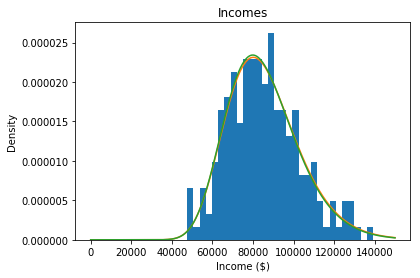

In [291]:
count, bins, patches = plt.hist(incomes, bins = 30, normed = True)
plt.title('Incomes')
plt.xlabel('Income ($)')
plt.ylabel('Density')
x = np.linspace(1, 150000, 1000)
y_gmm3 = lognormal_pdf(x, gmm_3_params)
y_max = lognormal_pdf(x, gmm_params)
plt.plot(x, y_gmm3)
plt.plot(x, y_max)

Using different moments leads to almost identical results

Out of b and d they both fit the data very well.

### 2

Don't understand using MLE or GMM for linear regression yet. Sorry.